# This script is for testing the susceptibility calculations done by PCF. 
Currently the "susceptibility()" function produces orders of magnitude higher than measured for our compound. The function computes numerical derivatives from magnetization.

Using PCF's "magnetization()" function and computing M/H manually does not produce the same results as PCF's susceptibility function. But it does seem to get closer to measurements.

PCF has a "susceptibilityPert()" function which calculates susceptibility from perturbation theory, but it only supports J Basis. Also, it currently only prduces nans.

In [15]:
import sys
sys.path.append('..')
from JensenTools import *

## Declare important variables.

In [16]:
# kwargs
#####################################################################################################################################################################
comp = 'Sr2PrO4'
ion = 'Ce3+'
who = 'Arun'
LS_on = True
Kmeans = True
LSValue = 100
numlevels = 4
per = 'spin'

# The L,S values are as follows for the Pr4+ ion
L = 3
S = 0.5
massErr = .00005
molweight = molweight[comp]
#####################################################################################################################################################################

## Create the CFLevels object from best fit parameters.

In [17]:
# Make LS_CFLevels object with best fit parameters
#####################################################################################################################################################################
if LS_on:
    B20  =  0.4858075931009187
    B40  =  -0.6568663783690575
    B44  =  -3.1415463304732714
    B60  =  -0.02328250024945387
    B64  =  0.504906552605772
    LS  =  100.00007580463522
    B40J  =  -0.5572886105373519
    B60J  =  0.4673
    B44J  =  -3.0946858584804335
    B64J  =  -9.8133
    B20J  =  12.606195720794622
else:
    B40  =  -0.5572886105373519
    B60  =  0.4673
    B44  =  -3.0946858584804335
    B64  =  -9.8133
    B20  =  12.606195720794622

saveDir = getSaveDir('m',comp = comp) #General Directory for the project
MTDir = getSaveDir('m',comp = comp, dataType = 'MT') #MvsT data

stevLS = { 'B20' :B20, 'B40': B40, 'B44' : B44, 'B60': B60, 'B64' : B64 }
stevJ = { 'B20' :B20J, 'B40': B40J, 'B44' : B44J, 'B60': B60J, 'B64' : B64J }

#Create the CFLevels object and diagonalize it
if LS_on:
    Pr = cef.LS_CFLevels.Bdict(Bdict = stevLS, L = L, S = S, SpinOrbitCoupling=LS)
    PrJ = cef.CFLevels.Bdict(Bdict = stevJ, ion = 'Ce3+')
    Pr.diagonalize()
    PrJ.diagonalize()
else:
    Pr = cef.CFLevels.Bdict(Bdict = stev, ion = 'Ce3+')
    Pr.diagonalize()
#####################################################################################################################################################################

## Load susceptibility data from measurement and normalize it either per mol or spin. (PCF calculates per spin). Choose ZFC or FC.

In [18]:
# Loading data for M vs T 
#####################################################################################################################################################################
runs = []
for i in os.listdir(MTDir):
    if i.endswith('.DAT') or i.endswith('.dat'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)
MTdata = {}
for i in runs:
    M,H,T,MErr,mass,measType = getData(i,MTDir, who = who, dataType = 'MT')
    M = normalize(M,mass,molweight,per)
    Merr = normalize(MErr,mass,molweight,per)
    MTdata[measType] = [M,H,T,MErr,mass]

#Either 'ZFC' or 'FC'
M,H,T,MErr,mass = MTdata['FC']
#####################################################################################################################################################################

## Use PCF's susceptibility function to calculate.

In [19]:
# Use PCF function to calculate Susceptibility (uB/Tesla/Spin) over T
#####################################################################################################################################################################
fieldT = 0.1 #To match Arun's measurements
deltaField = .00001
if LS_on:
    XCalcBohrLS = Pr.susceptibility(Temps = T, Field = fieldT, deltaField = deltaField)
    XCalcBohrJ = PrJ.susceptibility(Temps = T, Field = fieldT, deltaField = deltaField, ion = ion)
else:
    XCalcBohr = Pr.susceptibility(Temps = T, Field = fieldT, deltaField = deltaField, ion = ion)
#####################################################################################################################################################################

## Use PCF's magnetization and calculate M/H.

In [22]:
# Use PCF function to calculate Magnetization (uB/spin) at fixed Field (.1T) over temop range
# Divide this magnetization by field to get Susceptibiltiy in (uB/T/spin)
#####################################################################################################################################################################
Ha = .1
magCalcBohrLS = []
magCalcBohrJ = []
magCalcBohrLSPowder = []
magCalcBohrJPowder = []
for i in T:
    if LS_on:
        magCalcBohrLS.append(Pr.magnetization( Temp = i, Field = [0, 0, Ha])[2])
        magCalcBohrJ.append(PrJ.magnetization( Temp = i, Field = [0, 0, Ha], ion = ion)[2])
        magCalcBohrLSPowder.append((Pr.magnetization(Temp = i, Field = [Ha, 0, 0])[0] + Pr.magnetization(Temp = i, Field = [0, i, 0])[1] + Pr.magnetization(Temp = i, Field = [0, 0, i])[2])/3)
        magCalcBohrJPowder.append((PrJ.magnetization(Temp = i, Field = [Ha, 0, 0], ion = ion)[0] + PrJ.magnetization(Temp = i, Field = [0, Ha, 0], ion = ion)[1] + PrJ.magnetization(Temp = i, Field = [0, 0, Ha], ion = ion)[2])/3)

    else:
        magCalcBohr.append(Pr.magnetization( Temp = i, Field = [0, 0, Ha], ion = ion)[2])

susLS = np.array(magCalcBohrLS)/Ha
susJ = np.array(magCalcBohrJ)/Ha
susLSPowder = np.array(magCalcBohrLSPowder)/Ha
susJPowder = np.array(magCalcBohrJPowder)/Ha
#####################################################################################################################################################################

PCFRatioLS = XCalcBohrLS/susLS
PCFRatioJ = XCalcBohrJ/susJ
PCFRatioLSPowder = XCalcBohrLS/susLSPowder
PCFRatioJPowder = XCalcBohrJ/susJPowder

## Plot

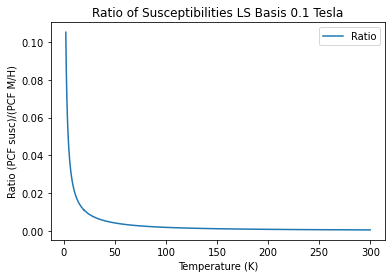

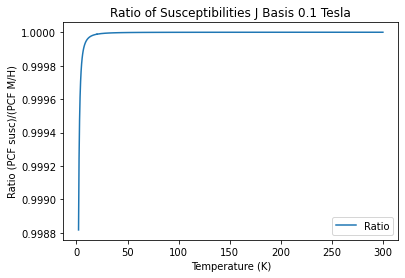

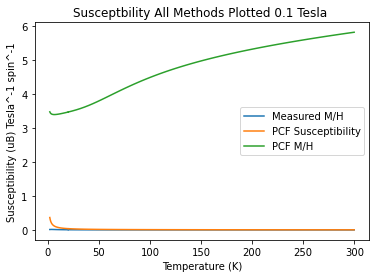

In [21]:
# Plotting
#####################################################################################################################################################################
# Plot ratio of calculated PCFs (LS)
plt.figure()
plt.plot(T,PCFRatioLSPowder, label = 'Ratio')
plt.xlabel('Temperature (K)')
plt.ylabel('Ratio (PCF susc)/(PCF M/H)')
plt.legend()
plt.title('Ratio of Susceptibilities LS Basis {} Tesla'.format(Ha))
plt.show()

# Plot ratio of calculated PCFs (J)
plt.figure()
plt.plot(T,PCFRatioJPowder, label = 'Ratio')
plt.xlabel('Temperature (K)')
plt.ylabel('Ratio (PCF susc)/(PCF M/H)')
plt.legend()
plt.title('Ratio of Susceptibilities J Basis {} Tesla'.format(Ha))
plt.show()



# # Plot PCF M/H
# plt.figure()
# plt.plot(T,-1*np.array(sus), label = 'PCF')
# plt.xlabel('Temperature (K)')
# plt.ylabel('Susceptibility (uB) Tesla^-1 spin^-1')
# plt.legend()
# plt.title('PCF M/H {} Tesla'.format(Ha))
# # plt.show()

# #Plot PCF Susc
# plt.figure()
# plt.plot(T,-1*XCalcBohr, label = 'PCF')
# plt.xlabel('Temperature (K)')
# plt.ylabel('Susceptibility (uB) Tesla^-1 spin^-1')
# plt.legend()
# plt.title('PCF Susceptbility {} Tesla '.format(Ha))
# # plt.show()


M = emuToBohr2(M)
H = oeToTesla(H)
# Plot experimental susc (M/H)
# plt.figure()
# plt.plot(T,M/H, label = 'Measured')
# plt.xlabel('Temperature (K)')
# plt.ylabel('Susceptibility (uB) Tesla^-1 spin^-1')
# plt.legend()
# plt.title('Measured Susceptbility {} Tesla '.format(Ha))



# Overplot all 3
plt.figure()
plt.plot(T,M/H, label = 'Measured M/H')
plt.plot(T,-1*XCalcBohrLS, label = 'PCF Susceptibility')
plt.plot(T,-1*np.array(susLSPowder), label = 'PCF M/H')
plt.xlabel('Temperature (K)')
plt.ylabel('Susceptibility (uB) Tesla^-1 spin^-1')
plt.legend()
plt.title('Susceptbility All Methods Plotted {} Tesla '.format(Ha))

plt.show()
#####################################################################################################################################################################